1. Generate random numbers for the Black-Scholes model parameters
2. Calculate call option prices.
3. Buill an ANN on this.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

We will focus on call options. The formula is given below:

$c = {S_0}N(d_1) - Ke^{-rT}N(d_2)$</br>
$d_1 = \frac{ \ln{\frac{S_0}{K}} + (r+0.5{\sigma}^2)T}{\sigma\sqrt{T}}$</br>
$d_2 = d_1 - \sigma\sqrt{T} $


S<sub>0</sub> = stock price at time 0</br>
K = strike Price</br>
r = risk free rate of interest</br>
T = time to maturity of the call option</br>
$\sigma$ = volatility of the stock price</br>

N(x) = Cumulative distribution function of a standard normal random variable x

## Random Number Generation of the parameters


In [2]:
m = 20000

S = np.random.uniform(100,150,m)
K = np.random.uniform(0.5*S,1.5*S,m)
r = np.random.uniform(0,0.05,m)
sigma = np.random.uniform(0.1,0.4,m)
T = np.random.uniform(0.25,1,m)

## Calculate Call Option prices using Black Scholes Formula

In [3]:
def get_bs_call(S,K,r,sigma,T):
    
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    c = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    return c
    

In [4]:
C = []

for i in range(m):
    
    calls = get_bs_call(S[i],K[i],r[i],sigma[i],T[i])
    C.append(calls)

## Prepare the data to train the ANN

In [5]:
data = {'Spot Price':S,'Strike Price':K,'Risk free rate':r,'Volatility':sigma,'Maturity(yrs)':T,'Call price':C}
df = pd.DataFrame(data)

In [6]:
df.head()

,Spot Price,Strike Price,Risk free rate,Volatility,Maturity(yrs),Call price
0,110.912024,141.398356,0.027970,0.153764,0.772532,0.355854
1,118.421798,175.553011,0.042382,0.362933,0.363090,0.529535
2,126.481876,182.519771,0.001708,0.105890,0.524167,0.000002
3,139.986255,180.928097,0.030799,0.129659,0.418294,0.007036
4,113.820783,154.433944,0.026672,0.177290,0.967701,0.526994


In [7]:
X = df.drop('Call price',axis =1)
y = df['Call price']

In [8]:
# divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=100)

# divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

In [9]:
# Scale features
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [10]:
tf.random.set_seed(123)
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)), #the input layer
    keras.layers.Dense(20,activation='sigmoid'), #hidden layer with 20 neurons and sigmoid activation function
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(20,activation='sigmoid'),
    keras.layers.Dense(1,activation='linear') 
])

model1.compile(optimizer = 'adam',loss = 'mse')
model1.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [11]:
history1 = model1.fit(X_scaled_train,y_train,epochs=100,validation_data=(X_scaled_vals,y_val))

Epoch 1/100


2023-07-08 12:03:50.811120: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


352/352 [==============================] - 2s 5ms/step - loss: 612.8282 - val_loss: 520.6284
Epoch 2/100
352/352 [==============================] - 2s 5ms/step - loss: 468.9935 - val_loss: 433.7925
Epoch 3/100
352/352 [==============================] - 2s 5ms/step - loss: 412.5662 - val_loss: 401.9819
Epoch 4/100
352/352 [==============================] - 2s 5ms/step - loss: 386.8576 - val_loss: 349.2570
Epoch 5/100
352/352 [==============================] - 2s 5ms/step - loss: 256.0529 - val_loss: 198.1744
Epoch 6/100
352/352 [==============================] - 2s 5ms/step - loss: 164.5710 - val_loss: 137.3658
Epoch 7/100
352/352 [==============================] - 2s 5ms/step - loss: 116.7178 - val_loss: 98.9711
Epoch 8/100
352/352 [==============================] - 2s 5ms/step - loss: 83.1319 - val_loss: 69.7591
Epoch 9/100
352/352 [==============================] - 2s 5ms/step - loss: 58.6141 - val_loss: 49.5905
Epoch 10/100
352/352 [==============================] - 2s 5ms/step - lo

352/352 [==============================] - 2s 5ms/step - loss: 0.0244 - val_loss: 0.0216
Epoch 82/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0244 - val_loss: 0.0231
Epoch 83/100
352/352 [==============================] - 2s 6ms/step - loss: 0.0236 - val_loss: 0.0224
Epoch 84/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 85/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0235 - val_loss: 0.0227
Epoch 86/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0228 - val_loss: 0.0275
Epoch 87/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0229 - val_loss: 0.0207
Epoch 88/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 89/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0229 - val_loss: 0.0206
Epoch 90/100
352/352 [==============================] - 2s 5ms/step - loss: 0.0218 - val_loss: 

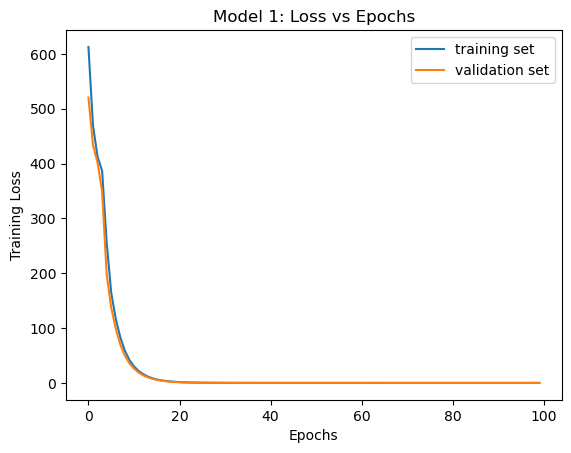

In [12]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Model 1: Loss vs Epochs")
plt.legend(['training set','validation set'])
plt.show()

In [13]:
model1.evaluate(X_scaled_test,y_test)

157/157 [==============================] - 1s 4ms/step - loss: 0.0192


0.01923130452632904

**It appears that the machine has fit the model quite well!**

In [14]:
preds1 = model1.predict(X_scaled_test)

157/157 [==============================] - 0s 1ms/step


In [25]:
print(len(preds1))

count = 0

for i in range(5000):
    
    if preds1[i]<0:
        count+=1
print(count)

5000
240


In [16]:
mse = np.mean((preds1-y_test)**2)
mse

770.0657048269371

In [21]:
d1 = np.array([[110.912024,141.398356,0.027970,0.153764,0.772532]])
print(get_bs_call(110.912024,141.398356,0.027970,0.153764,0.772532))
model1.predict(d1)

0.3558523759460197
1/1 [==============================] - 0s 16ms/step


array([[-0.16930413]], dtype=float32)

In [ ]:
#sigma, st (ANN - market)^2 sum is mini